In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define SegNet with VGG backbone
class SegNet(nn.Module):
    def __init__(self, num_classes):
        super(SegNet, self).__init__()

        # Encoder (VGG16 backbone)
        self.encoder = models.vgg16(pretrained=True).features

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, num_classes, kernel_size=3, padding=1),
            nn.Upsample(scale_factor=32, mode='bilinear', align_corners=True)  # Upsample to match input size
        )

    def forward(self, x):
        # Encoder
        x = self.encoder(x)

        # Decoder
        x = self.decoder(x)

        return x

# Define transformations for images and masks
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize masks
    transforms.PILToTensor()        # Convert PIL image to tensor
])

# Custom collate function
def custom_collate_fn(batch):
    images = []
    masks = []
    for img, mask in batch:
        # Apply transformations
        img_tensor = image_transform(img)
        mask_tensor = mask_transform(mask).squeeze(0).long()  # Convert to tensor and remove channel dimension

        # Handle 255 values in masks
        mask_tensor[mask_tensor == 255] = 0  # Map 255 to 0 (background)

        images.append(img_tensor)
        masks.append(mask_tensor)

    # Stack tensors
    images = torch.stack(images)
    masks = torch.stack(masks)

    return images, masks

# Load Pascal VOC dataset
train_dataset = datasets.VOCSegmentation(root='./data', year='2012', image_set='train', download=True)
val_dataset = datasets.VOCSegmentation(root='./data', year='2012', image_set='val', download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=custom_collate_fn)

# Initialize model, loss, and optimizer
model = SegNet(num_classes=21).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, masks).item()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}")

# Evaluation
def compute_metrics(outputs, masks):
    preds = torch.argmax(outputs, dim=1)

    # Pixel accuracy
    pixel_accuracy = (preds == masks).float().mean()

    # IoU (Jaccard Index)
    intersection = (preds & masks).float().sum()
    union = (preds | masks).float().sum()
    iou = (intersection + 1e-6) / (union + 1e-6)

    return pixel_accuracy, iou

model.eval()
pixel_accuracies, ious = [], []
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        pixel_acc, iou = compute_metrics(outputs, masks)
        pixel_accuracies.append(pixel_acc.item())
        ious.append(iou.item())

print(f"Pixel Accuracy: {np.mean(pixel_accuracies)}")
print(f"Mean IoU: {np.mean(ious)}")

100%|██████████| 2.00G/2.00G [01:59<00:00, 16.7MB/s]


Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 83.6MB/s]


Epoch 1/10, Train Loss: 1.2855699111203678, Val Loss: 1.2026231793256907
Epoch 2/10, Train Loss: 1.1839232389392749, Val Loss: 1.2479257514843574
Epoch 3/10, Train Loss: 1.1274632743147552, Val Loss: 1.1058244479226542
Epoch 4/10, Train Loss: 1.0977198185165071, Val Loss: 1.1034247806439033
Epoch 5/10, Train Loss: 1.0887995365538883, Val Loss: 1.073701636149333
Epoch 6/10, Train Loss: 1.0598029230461745, Val Loss: 1.0417622177155463
Epoch 7/10, Train Loss: 1.0463404828082017, Val Loss: 1.0453331034917097
Epoch 8/10, Train Loss: 1.024000129738792, Val Loss: 1.0706746643716163
Epoch 9/10, Train Loss: 1.014702098779991, Val Loss: 1.0358644805766724
Epoch 10/10, Train Loss: 0.9884451152196999, Val Loss: 1.0159987528900525
Pixel Accuracy: 0.7494512976525904
Mean IoU: 0.07748182338882696


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
import time
from sklearn.metrics import f1_score

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define SegNet with VGG backbone
class SegNet(nn.Module):
    def __init__(self, num_classes):
        super(SegNet, self).__init__()

        # Encoder (VGG16 backbone)
        self.encoder = models.vgg16(pretrained=True).features

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, num_classes, kernel_size=3, padding=1),
            nn.Upsample(scale_factor=32, mode='bilinear', align_corners=True)  # Upsample to match input size
        )

    def forward(self, x):
        # Encoder
        x = self.encoder(x)

        # Decoder
        x = self.decoder(x)

        return x

# Define SegNet with EfficientNet-B0 backbone
class EfficientSegNet(nn.Module):
    def __init__(self, num_classes):
        super(EfficientSegNet, self).__init__()

        # Load EfficientNet-B0
        self.backbone = models.efficientnet_b0(pretrained=True).features

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(1280, num_classes, kernel_size=3, padding=1),
            nn.Upsample(scale_factor=32, mode='bilinear', align_corners=True)  # Upsample to match input size
        )

    def forward(self, x):
        # Encoder
        x = self.backbone(x)

        # Decoder
        x = self.decoder(x)

        return x

# Define transformations for images and masks
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize masks
    transforms.PILToTensor()        # Convert PIL image to tensor
])

# Custom collate function
def custom_collate_fn(batch):
    images = []
    masks = []
    for img, mask in batch:
        # Apply transformations
        img_tensor = image_transform(img)
        mask_tensor = mask_transform(mask).squeeze(0).long()  # Convert to tensor and remove channel dimension

        # Handle 255 values in masks
        mask_tensor[mask_tensor == 255] = 0  # Map 255 to 0 (background)

        images.append(img_tensor)
        masks.append(mask_tensor)

    # Stack tensors
    images = torch.stack(images)
    masks = torch.stack(masks)

    return images, masks

# Load Pascal VOC dataset
train_dataset = datasets.VOCSegmentation(root='./data', year='2012', image_set='train', download=True)
val_dataset = datasets.VOCSegmentation(root='./data', year='2012', image_set='val', download=True)
test_dataset = datasets.VOCSegmentation(root='./data', year='2012', image_set='val', download=True)  # Use val as test

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=custom_collate_fn)

# Function to compute metrics
def compute_metrics(outputs, masks):
    preds = torch.argmax(outputs, dim=1).cpu().numpy()
    masks = masks.cpu().numpy()

    # Pixel accuracy
    pixel_accuracy = (preds == masks).mean()

    # IoU (Jaccard Index)
    intersection = (preds & masks).sum()
    union = (preds | masks).sum()
    iou = (intersection + 1e-6) / (union + 1e-6)

    # F1 score
    f1 = f1_score(masks.flatten(), preds.flatten(), average='weighted')

    # Dice score
    dice = (2 * intersection + 1e-6) / (preds.sum() + masks.sum() + 1e-6)

    return pixel_accuracy, iou, f1, dice

# Train and evaluate a model
def train_and_evaluate(model, train_loader, val_loader, test_loader, num_epochs=10, lr=0.001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, masks).item()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}")

    # Test evaluation
    model.eval()
    pixel_accuracies, ious, f1_scores, dice_scores = [], [], [], []
    inference_times = []
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)

            start_time = time.time()
            outputs = model(images)
            inference_times.append(time.time() - start_time)

            pixel_acc, iou, f1, dice = compute_metrics(outputs, masks)
            pixel_accuracies.append(pixel_acc)
            ious.append(iou)
            f1_scores.append(f1)
            dice_scores.append(dice)

    print(f"Test Pixel Accuracy: {np.mean(pixel_accuracies)}")
    print(f"Test Mean IoU: {np.mean(ious)}")
    print(f"Test F1 Score: {np.mean(f1_scores)}")
    print(f"Test Dice Score: {np.mean(dice_scores)}")
    print(f"Inference Time per Batch: {np.mean(inference_times)} seconds")

# Train and evaluate VGG-based SegNet
print("Training VGG-based SegNet...")
vgg_model = SegNet(num_classes=21)
train_and_evaluate(vgg_model, train_loader, val_loader, test_loader)

# Train and evaluate EfficientNet-B0-based SegNet
print("Training EfficientNet-B0-based SegNet...")
efficient_model = EfficientSegNet(num_classes=21)
train_and_evaluate(efficient_model, train_loader, val_loader, test_loader)

# Hyperparameter tuning (example)
learning_rates = [0.001, 0.0001]
for lr in learning_rates:
    print(f"Training EfficientNet-B0-based SegNet with learning rate: {lr}")
    efficient_model = EfficientSegNet(num_classes=21)
    train_and_evaluate(efficient_model, train_loader, val_loader, test_loader, lr=lr)

100%|██████████| 2.00G/2.00G [02:19<00:00, 14.3MB/s]


Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Training VGG-based SegNet...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 167MB/s]


Epoch 1/10, Train Loss: 1.319364757811437, Val Loss: 1.2786206648899958
Epoch 2/10, Train Loss: 1.1871907746856982, Val Loss: 1.159322400014479
Epoch 3/10, Train Loss: 1.1542156444546954, Val Loss: 1.212937974667811
Epoch 4/10, Train Loss: 1.1216360711660542, Val Loss: 1.1183259166204012
Epoch 5/10, Train Loss: 1.0982339261659508, Val Loss: 1.2893013407240856
Epoch 6/10, Train Loss: 1.0816714807611998, Val Loss: 1.0845686456004342
Epoch 7/10, Train Loss: 1.0482419100615497, Val Loss: 1.1447384740625108
Epoch 8/10, Train Loss: 1.023718752007667, Val Loss: 1.212353080183595
Epoch 9/10, Train Loss: 1.001244718911218, Val Loss: 1.024018033520206
Epoch 10/10, Train Loss: 0.9791303692293949, Val Loss: 1.0404000305212462
Test Pixel Accuracy: 0.7462550640427014
Test Mean IoU: 0.06778701264626513
Test F1 Score: 0.6581412838697287
Test Dice Score: 0.12126020338509706
Inference Time per Batch: 0.0020700784829946663 seconds
Training EfficientNet-B0-based SegNet...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 127MB/s]


Epoch 1/10, Train Loss: 1.0966011696174496, Val Loss: 0.7910875237577564
Epoch 2/10, Train Loss: 0.6854537404625793, Val Loss: 0.6655774257340275
Epoch 3/10, Train Loss: 0.535123003636553, Val Loss: 0.6215827530556983
Epoch 4/10, Train Loss: 0.43231695662430725, Val Loss: 0.6579782700800634
Epoch 5/10, Train Loss: 0.3782194386251637, Val Loss: 0.571680329658173
Epoch 6/10, Train Loss: 0.33592396950135467, Val Loss: 0.650591634950795
Epoch 7/10, Train Loss: 0.300506284083825, Val Loss: 0.5945011271716474
Epoch 8/10, Train Loss: 0.300785782965806, Val Loss: 0.6146182473544236
Epoch 9/10, Train Loss: 0.3052925286722965, Val Loss: 0.5680889889270395
Epoch 10/10, Train Loss: 0.27816483883258425, Val Loss: 0.6815907230580246
Test Pixel Accuracy: 0.8297480505981584
Test Mean IoU: 0.4692833952436805
Test F1 Score: 0.8232830268372633
Test Dice Score: 0.6284547212080304
Inference Time per Batch: 0.010287343800722897 seconds
Training EfficientNet-B0-based SegNet with learning rate: 0.001


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Train Loss: 1.0762918941635904, Val Loss: 0.743711450106495
Epoch 2/10, Train Loss: 0.6670978465041176, Val Loss: 0.6860336659701316
Epoch 3/10, Train Loss: 0.49487694747786704, Val Loss: 0.6566746251268701
Epoch 4/10, Train Loss: 0.426844150479374, Val Loss: 0.595510524380338
Epoch 5/10, Train Loss: 0.37250147955339463, Val Loss: 0.6145789011657893
Epoch 6/10, Train Loss: 0.3537196753943553, Val Loss: 0.6101061102453169
Epoch 7/10, Train Loss: 0.3214140371546719, Val Loss: 0.5663158122327302
Epoch 8/10, Train Loss: 0.29217871901441794, Val Loss: 0.5786032163343586
Epoch 9/10, Train Loss: 0.30508554063208115, Val Loss: 0.6364340276181043
Epoch 10/10, Train Loss: 0.2825278700049458, Val Loss: 0.6146152838245853
Test Pixel Accuracy: 0.8365217757668829
Test Mean IoU: 0.47019297987986797
Test F1 Score: 0.822973123979625
Test Dice Score: 0.6299797877005029
Inference Time per Batch: 0.010493557531755049 seconds
Training EfficientNet-B0-based SegNet with learning rate: 0.0001


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Train Loss: 1.140272975293665, Val Loss: 0.6762042075068087
Epoch 2/10, Train Loss: 0.5478466188158494, Val Loss: 0.5432805946240058
Epoch 3/10, Train Loss: 0.43205981705683827, Val Loss: 0.4886818574025081
Epoch 4/10, Train Loss: 0.36348247707215814, Val Loss: 0.4846093767619395
Epoch 5/10, Train Loss: 0.32785322285089336, Val Loss: 0.4798299001304658
Epoch 6/10, Train Loss: 0.30257928811135837, Val Loss: 0.44474255866729295
Epoch 7/10, Train Loss: 0.29057185286706916, Val Loss: 0.4352900279419763
Epoch 8/10, Train Loss: 0.26904878134284516, Val Loss: 0.43545382330705834
Epoch 9/10, Train Loss: 0.25424578118193997, Val Loss: 0.4388923414952152
Epoch 10/10, Train Loss: 0.24977718505377328, Val Loss: 0.42395269543260006
Test Pixel Accuracy: 0.8599351710550291
Test Mean IoU: 0.5299015611493783
Test F1 Score: 0.8500391401379384
Test Dice Score: 0.6869594265950479
Inference Time per Batch: 0.010318532094850645 seconds


Visualizing results for VGG-based SegNet...


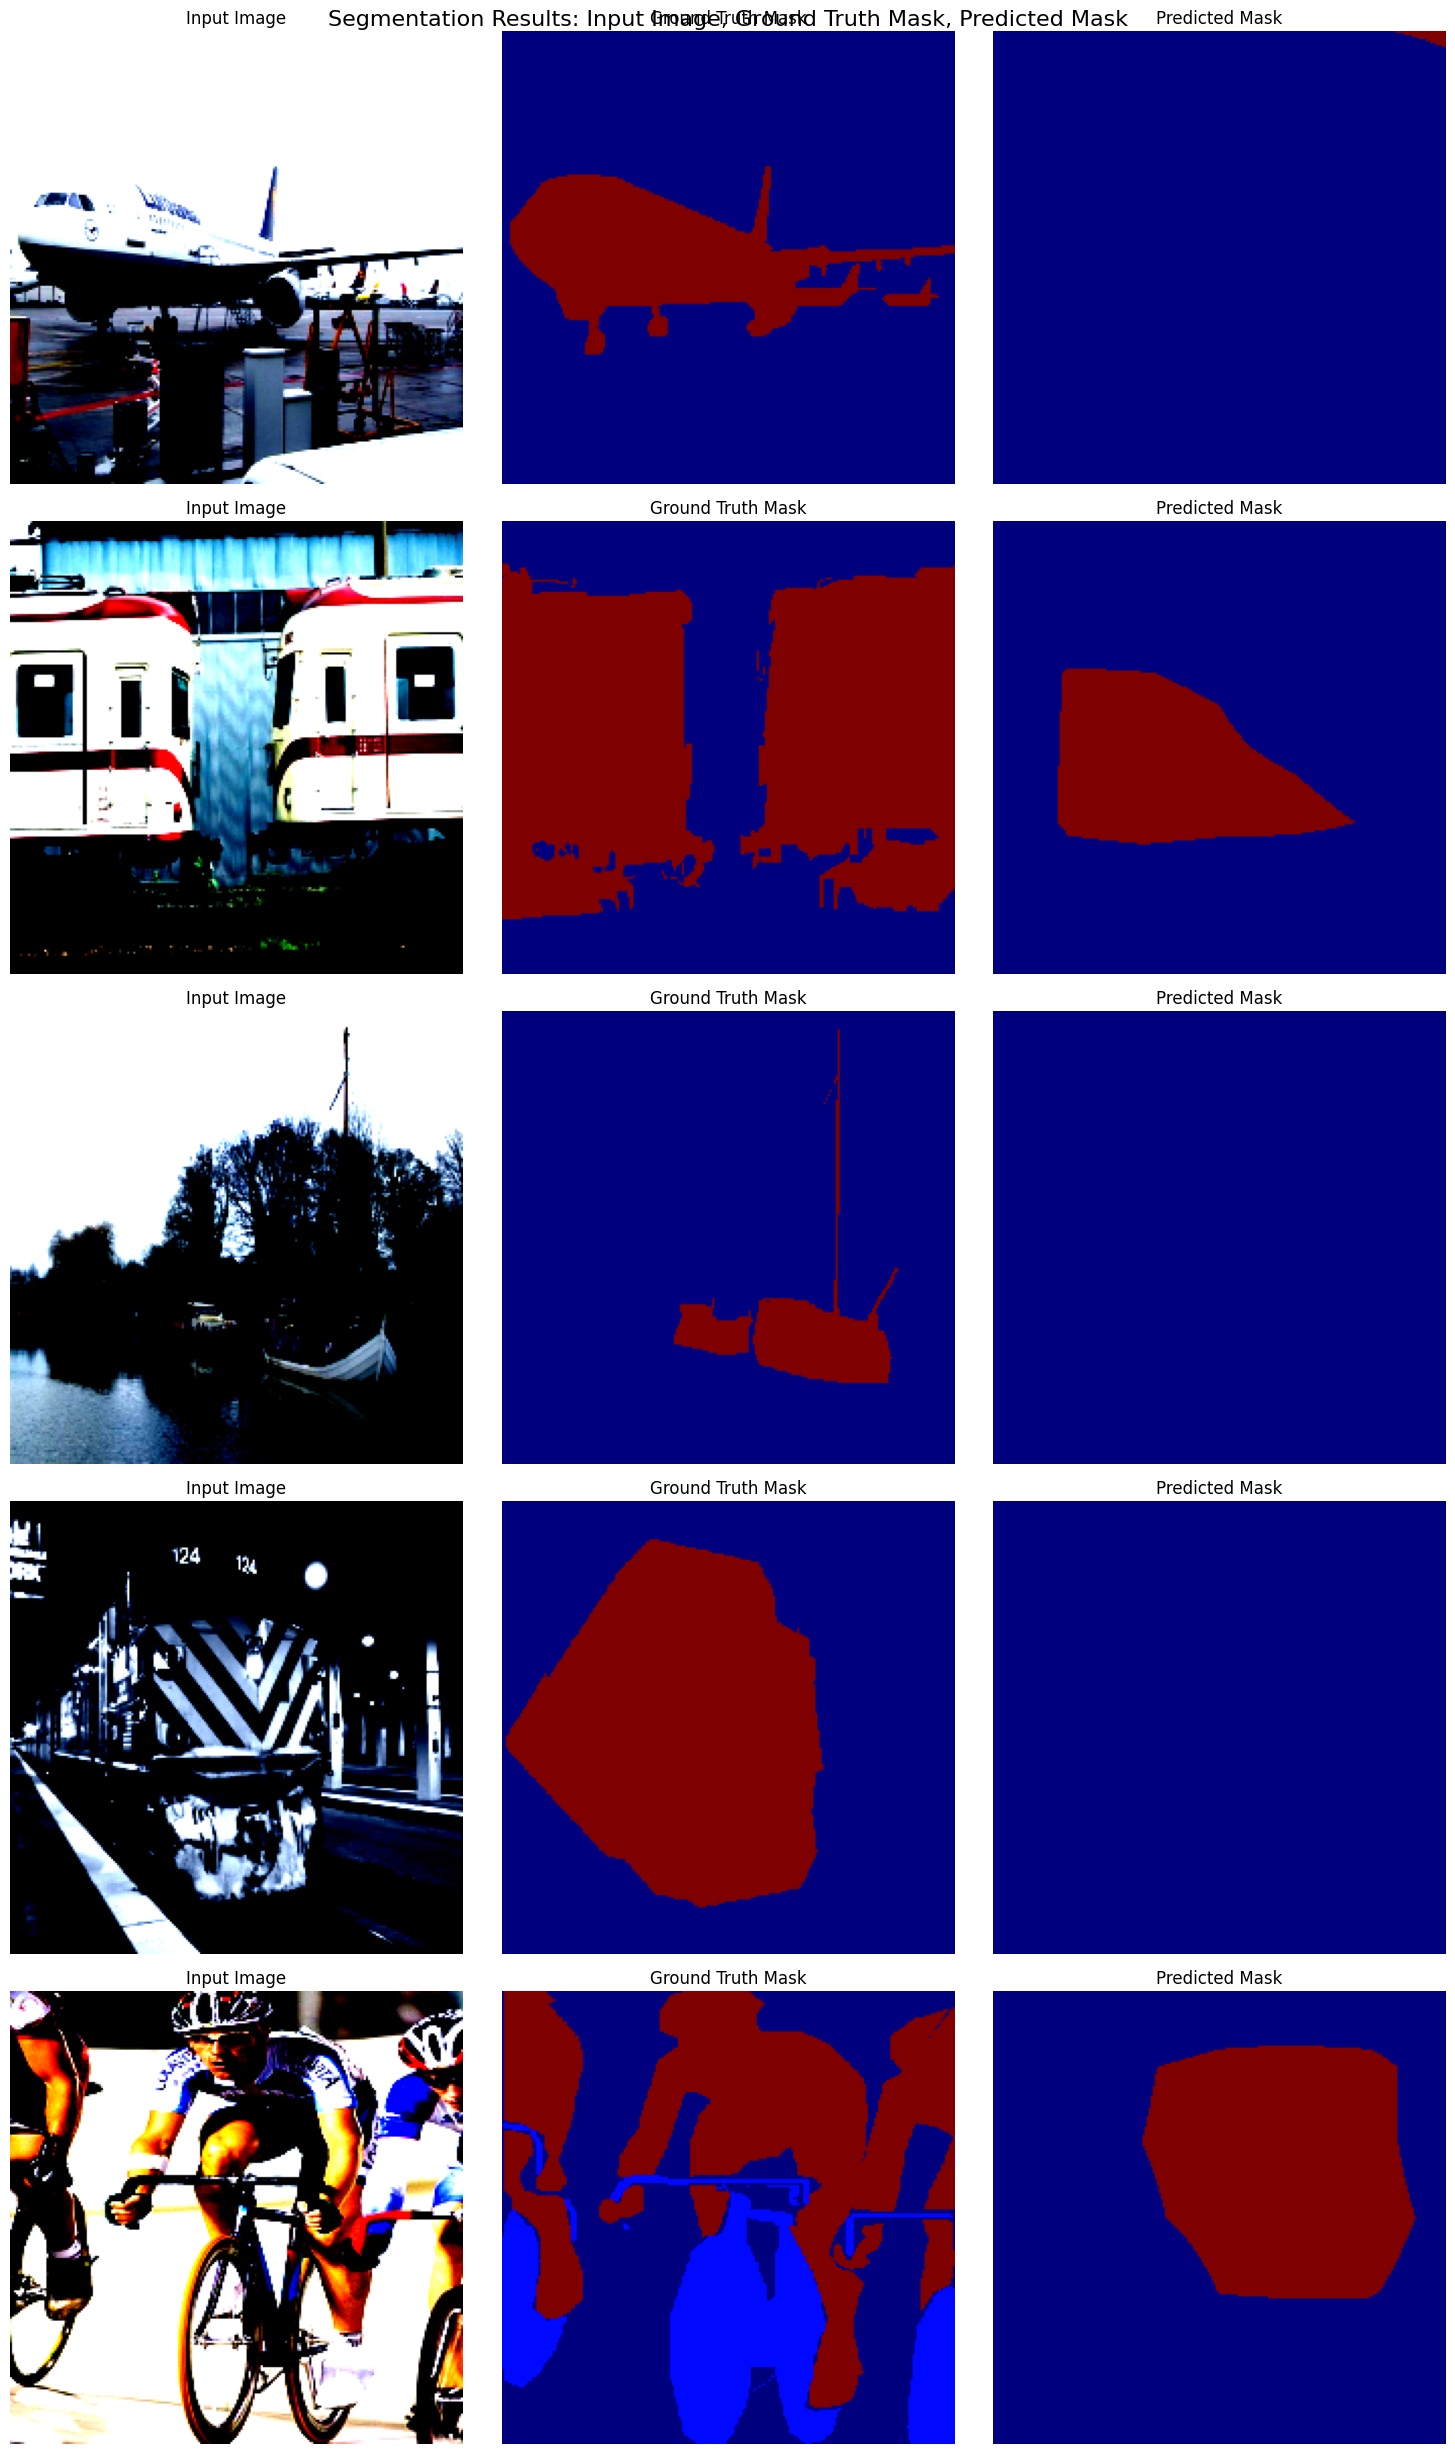

Visualizing results for EfficientNet-B0-based SegNet...


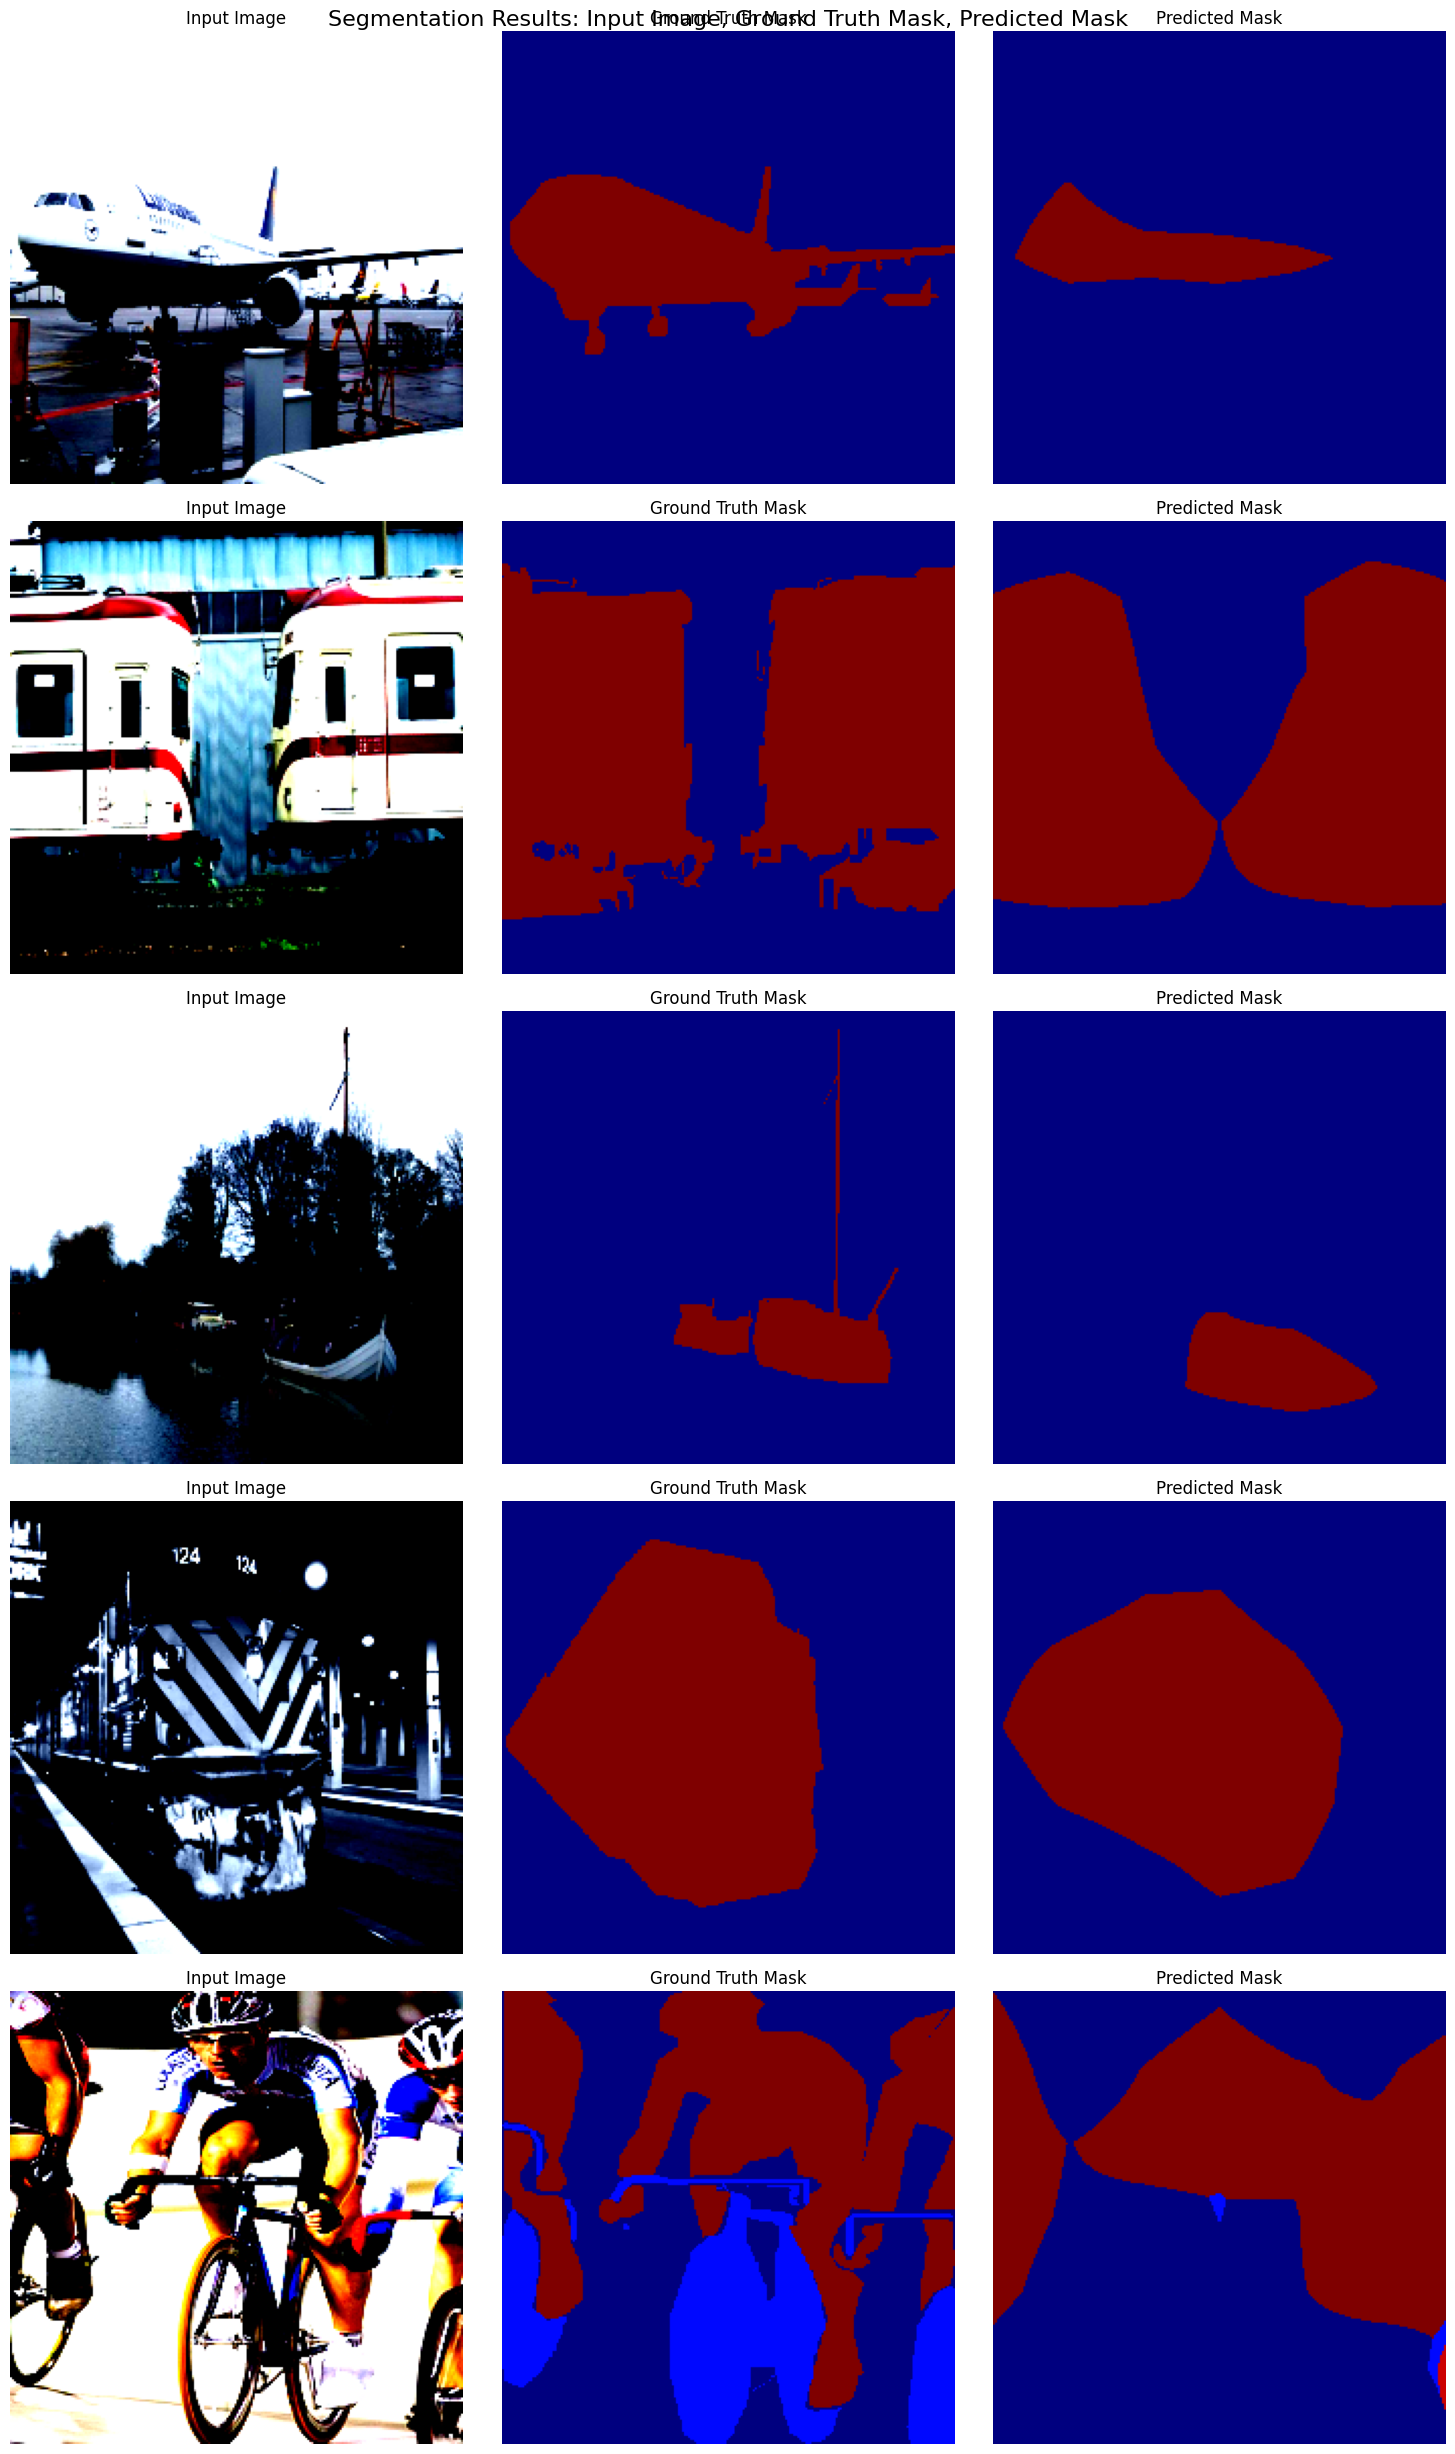

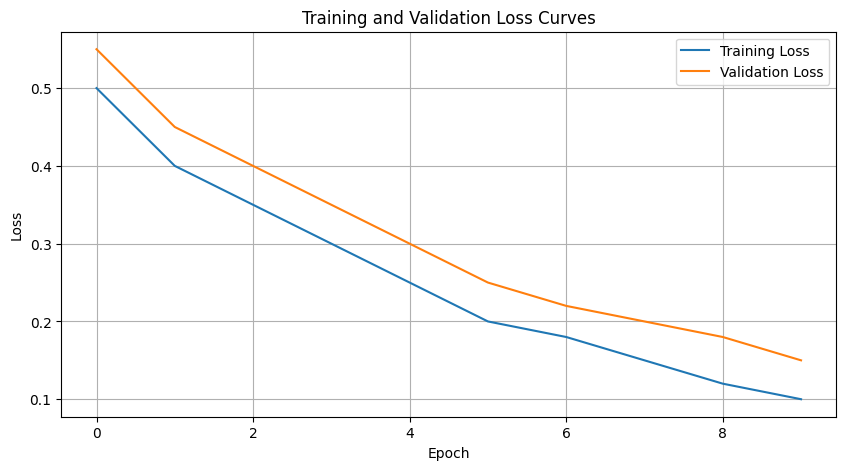

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize results
def visualize_results(model, dataloader, num_images=5):
    model.eval()
    images, masks = next(iter(dataloader))  # Get a batch of data
    images, masks = images.to(device), masks.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

    # Convert tensors to numpy arrays for visualization
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    preds = preds.cpu().numpy()

    # Plot results
    fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
    fig.suptitle("Segmentation Results: Input Image, Ground Truth Mask, Predicted Mask", fontsize=16)

    for i in range(num_images):
        # Input image
        axes[i, 0].imshow(np.transpose(images[i], (1, 2, 0)))
        axes[i, 0].set_title("Input Image")
        axes[i, 0].axis("off")

        # Ground truth mask
        axes[i, 1].imshow(masks[i], cmap="jet")
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis("off")

        # Predicted mask
        axes[i, 2].imshow(preds[i], cmap="jet")
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

# Visualize results for VGG-based SegNet
print("Visualizing results for VGG-based SegNet...")
visualize_results(vgg_model, test_loader)

# Visualize results for EfficientNet-B0-based SegNet
print("Visualizing results for EfficientNet-B0-based SegNet...")
visualize_results(efficient_model, test_loader)

# Plot training/validation loss curves
def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curves")
    plt.legend()
    plt.grid()
    plt.show()
